# I-Splines Implementation

In this notebook, we implement I-splines, a type of spline with the property of monotonicity. I-splines are constructed by integrating another type of spline known as the M-spline.

I-splines serve as the basis functions for creating monotonic splines, following the formula:
$$spline(x) = \sum_{i}c_{i}I_i(x)$$

We first present the recursive formula for M-splines and implement its code below, and then we'll present I-splines and its implementation.



In [1]:
# importinng packages
import torch
import matplotlib.pyplot as plt
import cvxopt
import numpy as np
cvxopt.solvers.options['show_progress'] = False

First Step : Defining M-splines

We define M-splines.
Given a sequence of knots t, An M-spline defined over an interval [a,b] is given by by the following formula:

For k=1 :
\begin{equation}
  M_i(x|1,t)=\begin{cases}
    \frac{1}{t_{i+1} - t_i}, & \text{if $t_i\leq x < t_{i+1}$}.\\
    0, & \text{Otherwise}
  \end{cases}
\end{equation}

For $k>1$ :

$$
M_i(x \mid k, t) = \frac{k \left[ (x - t_i) M_i(x \mid k-1, t) + (t_{i+k} - x) M_{i+1}(x \mid k-1, t) \right]}{(k-1)(t_{i+k} - t_i)}
$$

Where : $t=\{t_1, t_2, ... , t_{n+k}\}$ is a sequence of knots (that can be choosen) used to partition the domain interval [a,b], and n is the number of splines (i varies from 0 to n)


Implementation of M-splines



In [66]:
def m_spline(x, grid, k):
    """
    x is a 1D torch.tensor of shape (num_samples)
    grid is a 1D torch.tensor of shape (num_grid_points)
    k is an integer representing the spline order
    """

    grid_ = grid.unsqueeze(dim=0)   # grid_ = grid.unsqueeze(dim=0) to plot m-splines
    x_ = x.unsqueeze(dim=1)

    if k == 1:
        # Base case: Piecewise constant, normalized by denom
        denom = (grid_[:, 1:] - grid_[:, :-1])
        value = (x_ >= grid_[:, :-1]) * (x_ < grid_[:, 1:]) / denom


    elif k > 1:
        # Recursive case: M-splines of degree k-1
        Mkm1 = m_spline(x, grid, k-1)
        denom1 = (k-1)*(grid_[:, k:] - grid_[:, :-k])


        # Compute M-splines recursively
        value1 = (x_ - grid_[:, :-k]) * Mkm1[:, :-1]
        value2 = (grid_[:, k:] - x_) * Mkm1[:, 1:]

        value = (k * (value1 + value2)) / denom1


    value = torch.nan_to_num(value, nan=0.0)

    return value

We implement a function extend_grid() in order to handle boundary effects using padding. For an interval [0,1], We add k zeros to the beggining of the grid and k ones to the end.

In [67]:
def extend_grid(grid, k_extend=0):
    # Create tensors of zeros and ones with shape (num_splines, k_extend)
    zeros = torch.zeros((grid.shape[0], k_extend), dtype=grid.dtype, device=grid.device)
    ones = torch.ones((grid.shape[0], k_extend), dtype=grid.dtype, device=grid.device)

    # Concatenate zeros at the beginning and ones at the end for each row
    extended_grid = torch.cat([zeros, grid, ones], dim=1)

    return extended_grid

Visualization

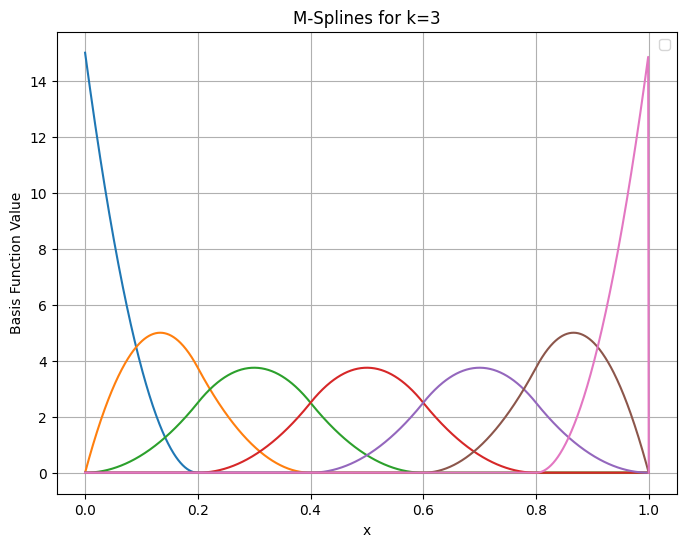

In [73]:
grid = torch.linspace(0, 1, steps=6)
grid = grid.unsqueeze(dim=0)
k=3
grid = extend_grid(grid, k-1)
grid = torch.squeeze(grid, dim=0)

x = torch.linspace(0, 1, steps=1000)
plt.figure(figsize=(8, 6))

m_values = m_spline(x, grid, k)
for i in range(m_values.shape[1]):
    plt.plot(x.numpy(), m_values[:, i].numpy())

# Customize the plot
plt.title('M-Splines for 'f'k={k}')
plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.legend()
plt.grid(True)
plt.show()

Second Step : Defining I-splines


Given a sequence of knots t, I-splines are given by the following formula:

For an index j such that $ t_j \leq x < t_{j+1}$ : \\
\begin{equation}
  I_i(x|k,t)=\begin{cases}
    0, & \text{if $i>j$}.\\
    1, & \text{if $i<j-k+1$}\\
    \sum_{m=i}^{j} (t_{m+k+1} - t_m)M_m(x|k+1,t)/(k+1), &\text{Otherwise}
  \end{cases}
\end{equation}



Before implementing the code for I-splines, we'll implement a function to find the index j for each data point x that satisfies the condition : $ t_j \leq x < t_{j+1}$


The function **find_max_index()** takes a value x and finds the largest index in the tensor grid where grid points are less than or equal to x. A binary mask is created to mark grid points that are less than or equal to x with 0, and grid points that are greater than x with 1. It then uses **torch.argmax** to find the index of the first 1 in the mask, i.e., the largest index. The function returns the index that satisfy the condition, if no index is found it returns the last index of grid.

In [11]:
def find_max_index(grid, x):
    mask = torch.where(grid <= x, 0, 1)
    index = torch.argmax(mask) -1
    # if no element satisfies the conditions, return the last index of grid
    return torch.where(index == -1, grid.shape[0] - 1, index)


Implementation of I splines

In [12]:
def i_spline(x, grid, k):
    """
    Input :

    x is a 2D torch.tensor of shape (num_samples, num_splines)
    grid is a 2D torch.tensor of shape (num_splines, num_grid_points)
    k is an integer representing the spline order
    Output
    Value a 3D tensor of shape (num_samples, num_splines, G+k) where G is the number of grid intervals and k is the degree of the spline
    """

    num_samples = x.shape[0]  # Number of samples
    num_splines = x.shape[1]  # Number of splines
    G = grid.shape[1] - 1     # Number of grid intervals

    # Initialize value with zeros
    value = torch.zeros(num_samples, num_splines, G + k)

    for i in range(num_splines):  # Loop over splines
        x_spline = x[:, i]  # Samples for the i-th spline
        grid_spline = grid[i, :]

        results = []
        # Loop over samples
        for idx, a in enumerate(x_spline):  # Track values in x_spline and their indices
            result = find_max_index(grid_spline, a)
            results.append(result)
            j_list = torch.stack(results)
            j = j_list[idx].item()  # Get the corresponding j for the current sample

            # Case 2: I(x) = 1 if  i < j - k + 1
            if i < j - k + 1:
                value[idx, i, :] = 1  # Set value to 1 across the (G + k) dimension

            # Case 3: recursive formula if i <= j and i >= j - k + 1
            elif j - k + 1 <= i <= j:
                # Calculate M-splines for k+1 order (calling the m_spline() function)
                Mkp1 = m_spline(x_spline, grid_spline, k + 1)
                t_mkp1 = grid_spline[i + k + 1 : j + k + 2]
                t_m = grid_spline[i : j + 1]

                # Summing values
                value[idx, i, :] = torch.sum(((t_mkp1 - t_m) * Mkp1[idx, i:j+1] / (k + 1)), dim=0)

            #handling boundary effects for x=1
            if a==1 :
                value[idx, i, :] = 1


    value = torch.nan_to_num(value, nan=0.0)
    return value

The following function **get_i_spline()** wraps the original function of **i_spline()** in order to handle the problem of getting constant splines.

In [35]:
def get_i_spline(x, grid, k):
  single_grid = grid[0,:]
  grid = single_grid.repeat(grid.shape[0] + 1, 1)
  x = torch.cat((x[:,0].unsqueeze(dim=1), x), dim=1)
  result = i_spline(x, grid, k)
  return result[:, 1:, :]

Visualization of monotone splines, I-splines.

In [71]:
num_splines = 7
num_grid_points = 6
num_samples = 100
k = 3

# Create the grid: Shape is (num_splines, num_grid_points)
grid = torch.linspace(0, 1, steps=num_grid_points).unsqueeze(0)  # Shape: (1, num_grid_points)
grid = grid.repeat(num_splines, 1)  # Shape: (num_splines, num_grid_points)
grid = extend_grid(grid, k_extend=k)

# Create x with the desired shape (num_splines, num_samples)
x = torch.linspace(0, 1, steps=num_samples).unsqueeze(1).repeat(1, num_splines)  # Shape: (num_samples, num_splines)
i_values = get_i_spline(x, grid, k)

In [37]:
print(i_values.shape)

torch.Size([100, 6, 13])


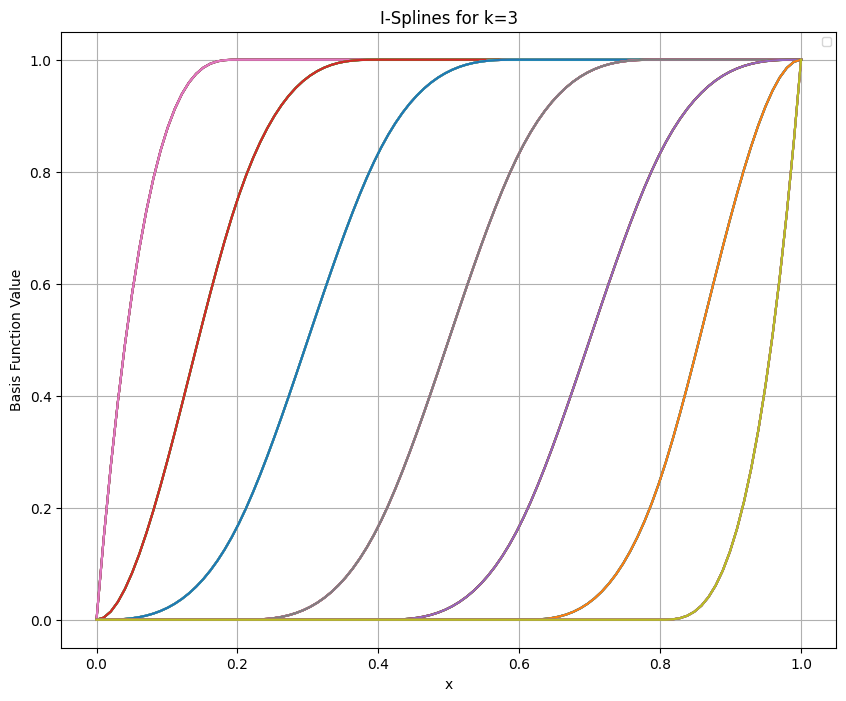

In [72]:
#Plotting i-splines
plt.figure(figsize=(10, 8))

for l in range(i_values.shape[1]):  # Loop over each spline
    plt.plot(x.numpy(), i_values[:, l, 0].numpy())

# Customize the plot
plt.title('I-Splines for 'f'k={k}')
plt.xlabel('x')
plt.ylabel('Basis Function Value')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True)
plt.show()


Third step : Learning coefficients

In this part we're inspired from the implementation of B-splines in this github repository : https://github.com/KindXiaoming/pykan . We'll be using the logique of two functions from their implementation and will be adding our own modifications.

The following **coef2curve_mono()** function converts I-spline coefficients into evaluated I-spline curves for a set of input values. It first calculates I-spline values at each evaluation point based on a given grid and degree k. Then, it multiplies these I-spline values by given coefficients, using Einstein summation to output the evaluations, following the formula : $spline(x) = \sum_{i}c_{i}I_i(x)$

In [24]:
def coef2curve_mono(x_eval, grid, coef, k, extend=True, device="cpu"):
    """
    converts I-spline coefficients to I-spline curves. Evaluates x on I-spline curves.
    Input :

    x_eval: (num_samples, num_splines), grid: (num_splines, num_grid_points), coef: (num_splines, out_dim, G+k)

    Output : y_eval 3D torch tensor with shape: (num_samples, num_splines, out_dim)
    """

    i_values = get_i_spline(x_eval, grid, k=k)  # i_spline: (num_samples, num_splines, G+k)
    y_eval = torch.einsum('ijk,jlk->ijl', i_values, coef.to(i_values.device))

    return y_eval

Test coef2curve_mono()

In [77]:
# Test parameters
num_samples = 100     # Number of samples
num_splines = 7       # Number of splines
out_dim = 5      # output dimension
G = 6          # Number of grid points
k = 3          # Spline order

# coefficients, grid and x_eval
grid = torch.linspace(0, 1, steps=G).repeat(num_splines, 1)
grid = extend_grid(grid, k_extend=k)
coef = torch.abs(torch.normal(0, 1, size=(num_splines, out_dim, grid.shape[1] + k -1))) #positive coefficients

x_eval = torch.linspace(0, 1, steps=num_samples).unsqueeze(1).repeat(1, num_splines)

i_values = get_i_spline(x_eval, grid, k)

print("i_values shape", i_values.shape)
print("Grid shape:", grid.shape)
print("x_eval shape:", x_eval.shape)
print("coef shape:", coef.shape)

y_eval = coef2curve_mono(x_eval, grid, coef, k)

print("Output shape of y_eval:", y_eval.shape)

i_values shape torch.Size([100, 7, 14])
Grid shape: torch.Size([7, 12])
x_eval shape: torch.Size([100, 7])
coef shape: torch.Size([7, 5, 14])
Output shape of y_eval: torch.Size([100, 7, 5])


Visualization of coef2curve_mono()

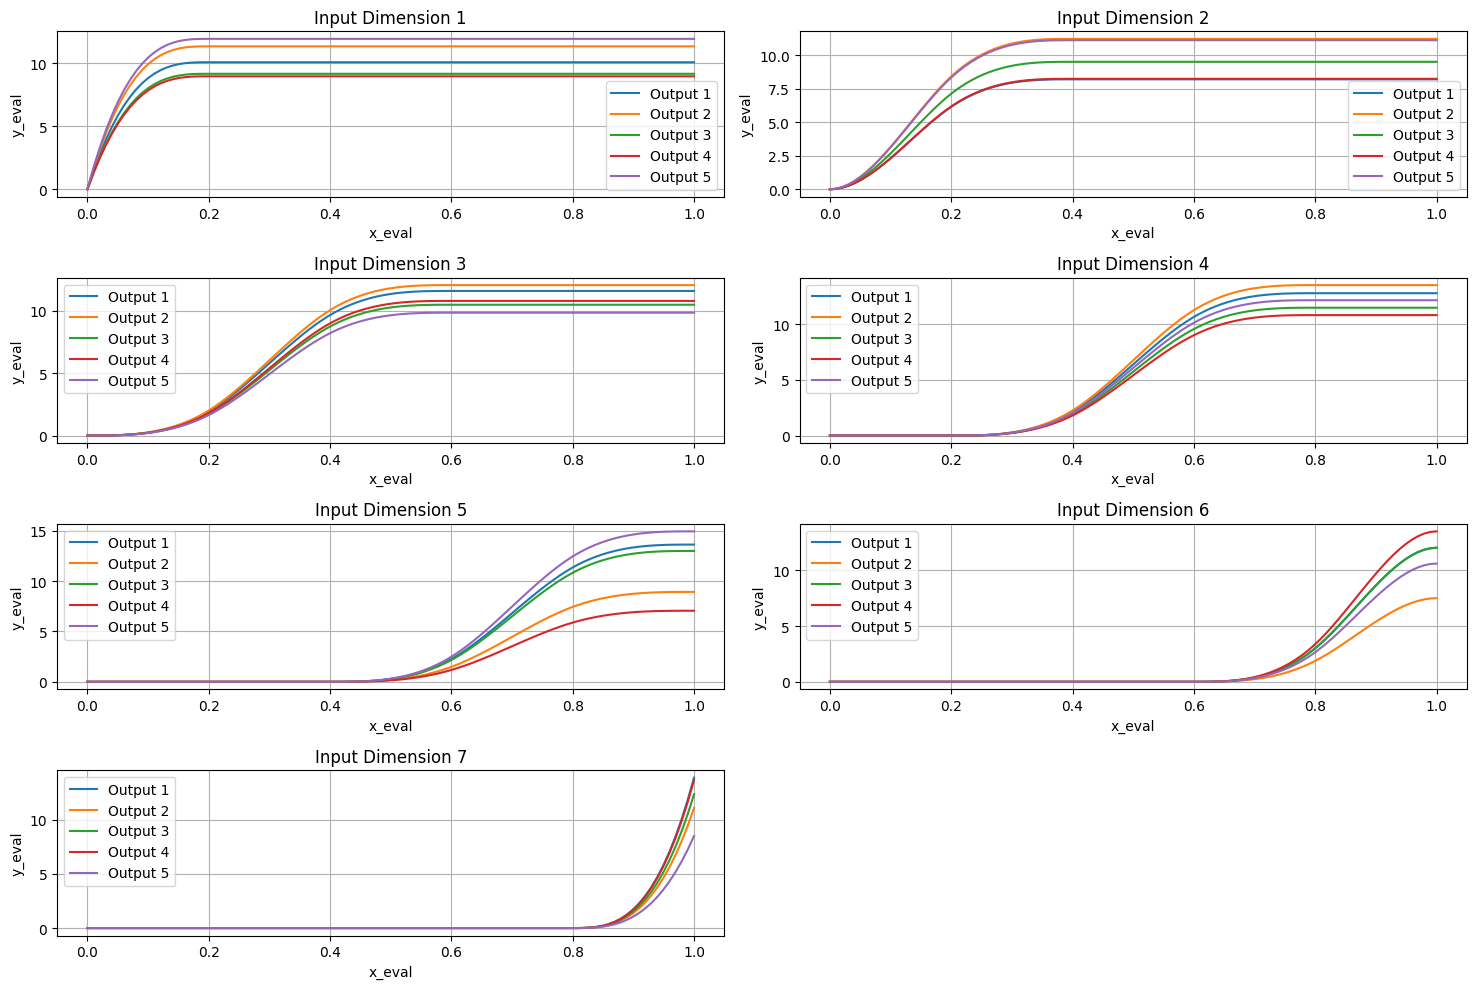

In [78]:
# Plotting coef2curve_mono() output
plt.figure(figsize=(15, 10))
for i in range(num_splines):  # Loop over each spline
    plt.subplot(4, 2, i + 1)
    for j in range(out_dim):
        plt.plot(x_eval[:, i].numpy(), y_eval[:, i, j].detach().numpy(), label=f'Output {j + 1}')

    plt.title(f'Input Dimension {i + 1}')
    plt.xlabel('x_eval')
    plt.ylabel('y_eval')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

The following **curve2coef_mono()** function converts I-spline curve values back into I-spline coefficients by solving a least-squares optimization problem under non-negativity constraint. It constructs the I-spline basis functions matrix, then calculates the regularized equations $Q = AᵀA + λI$ and $c = AᵀB$, and solves the least squares problem for each spline and output dimension using matrix inversion. We use a threshold to ensure non-negativity for the coefficients (coef)

In [48]:
def curve2coef_mono(x_eval, y_eval, grid, k, lamb=1e-3, extend=True, device='cpu'):
    """
    Convert I-spline curves to I-spline coefficients solving least squares with non-negativity constraints
    using matrix inversion and thresholding.

    Input:
        x_eval : 2D torch.tensor of shape (num_samples, num_splines)
        y_eval : 3D torch.tensor of shape (num_samples, num_splines, out_dim)
        grid : 2D torch.tensor of shape (num_splines, num_grid_points)
        k : int, spline order
        lamb : float, regularized least square lambda

    Output:
        coef : 3D torch.tensor of shape (num_splines, out_dim, G+k)
    """
    num_samples = x_eval.shape[0]
    num_splines = x_eval.shape[1]
    out_dim = y_eval.shape[2]
    n_coef = grid.shape[1] + k - 1

    # I-spline basis functions matrix
    mat = get_i_spline(x_eval, grid, k)  # shape: (num_samples, num_splines, G+k)

    mat = mat.permute(1, 0, 2)[:, None, :, :].expand(num_splines, out_dim, num_samples, n_coef)  # shape: (num_splines, out_dim, num_samples, n_coef)

    y_eval = y_eval.permute(1, 2, 0).unsqueeze(dim=3)  # shape: (num_splines, out_dim, num_samples, 1)
    device = mat.device

    # Construct A = mat and B = y_eval
    A = mat
    B = y_eval.to(A.device)

    # Compute A^T A and A^T B
    AtA = torch.einsum('ijmn,ijnp->ijmp', A.permute(0, 1, 3, 2), A) #shape (num_splines, out_dim, n_coef, n_coef)
    AtB = torch.einsum('ijmn,ijnp->ijmp', A.permute(0, 1, 3, 2), B) #shape (num_splines, out_dim, n_coef, 1)

    # Identity matrix for regularization term
    n1, n2, n = AtA.shape[0], AtA.shape[1], AtA.shape[2]
    identity = torch.eye(n,n)[None, None, :, :].expand(n1, n2, n, n).to(A.device)

    # Add regularization to AtA
    Q = AtA + lamb * identity  # Q = (A^T A + lambda*I)
    c = AtB   # c = A^T B

    # Initialize coefficients
    coef = torch.zeros(num_splines, out_dim, n_coef, device=device)

    # Iterate over splines and output dimensions
    for i in range(num_splines):
        for j in range(out_dim):

            Q_j = Q[i, j]  # (n_coef, n_coef)
            c_j = c[i, j]  # (n_coef, 1)

            # Invert the matrix Q_j (regularized matrix)
            Q_j_inv = torch.linalg.inv(Q_j)  # Inverse of Q_j
            coef_j = Q_j_inv @ c_j  # Solution: coef_j = inv(Q_j) * c_j

            # Apply threshold to ensure non-negativity
            coef_j = torch.clamp(coef_j, min=0)

            coef[i, j] = coef_j.squeeze(-1)  # Remove last dimension

    return coef


Testing curve2coef_mono()

In [49]:
y_eval = coef2curve_mono(x_eval, grid, coef, k)

# Convert y_eval back to coefficients
new_coef = curve2coef_mono(x_eval, y_eval, grid, k)
print("Output shape of coefficients:", coef.shape)

Output shape of coefficients: torch.Size([7, 5, 14])


Output Visualization

In [50]:
print(new_coef)

tensor([[[0.9428, 0.6824, 0.8666, 1.1300, 0.7394, 0.9057, 1.1613, 0.7863,
          0.9113, 0.8164, 1.0921, 0.7171, 0.9034, 1.0040],
         [0.7565, 0.5511, 0.7441, 0.8703, 0.6359, 0.7050, 0.9328, 0.6515,
          0.7453, 0.6521, 0.8931, 0.6588, 0.7453, 0.8294],
         [0.6932, 0.6882, 0.7892, 0.8676, 0.6020, 0.8126, 1.0238, 0.6645,
          0.8363, 0.6490, 0.9690, 0.6253, 0.7738, 0.8725],
         [0.6713, 0.4643, 0.6066, 0.6839, 0.5159, 0.6613, 0.7972, 0.5784,
          0.6878, 0.4706, 0.8034, 0.5300, 0.5980, 0.6066],
         [0.6320, 0.5129, 0.5471, 0.6960, 0.5007, 0.6135, 0.7194, 0.5007,
          0.6100, 0.4716, 0.6782, 0.5219, 0.5163, 0.5637]],

        [[1.7756, 0.7938, 1.1844, 1.1448, 0.8708, 0.9411, 0.6593, 0.7609,
          0.9327, 1.1593, 1.1280, 1.0812, 1.1049, 1.1174],
         [1.2294, 0.5183, 0.8386, 0.8811, 0.6618, 0.6931, 0.4620, 0.6222,
          0.7628, 0.7902, 0.8214, 0.7355, 0.7651, 0.7324],
         [1.0940, 0.4089, 0.7018, 0.7306, 0.5758, 0.5641, 0.4445, 0

Plotting I-splines with learned coefficients

In [51]:
# New y_eval using learned coefficients
new_y_eval = coef2curve_mono(x_eval, grid, new_coef, k)

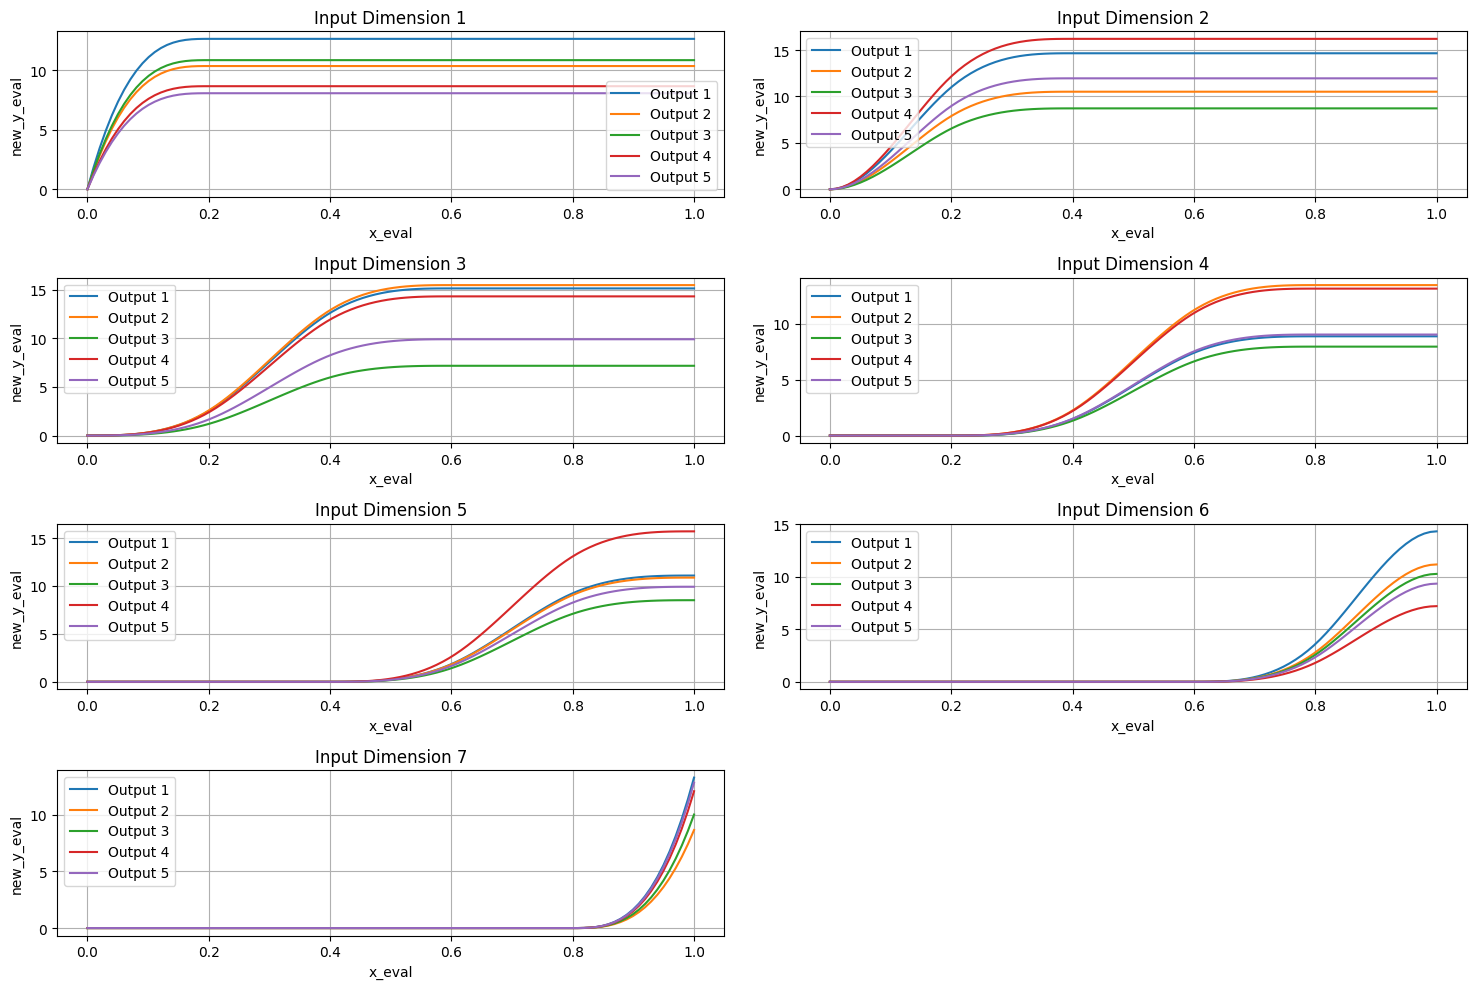

In [52]:
plt.figure(figsize=(15, 10))
for i in range(num_splines):  # Loop over each spline
    plt.subplot(4, 2, i + 1)
    for j in range(out_dim):
        plt.plot(x_eval[:, i].numpy(), new_y_eval[:, i, j].detach().numpy(), label=f'Output {j + 1}')

    plt.title(f'Input Dimension {i + 1}')
    plt.xlabel('x_eval')
    plt.ylabel('new_y_eval')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [53]:
#Checking for nan values
has_nan = torch.isnan(coef).any()

if has_nan:
    print("The coefficients contain NaN values.")
else:
    print("The coefficients do not contain any NaN values.")


The coefficients do not contain any NaN values.


In [54]:
# Check if all values in coef are positive
all_positive = (coef >= 0).all()

# Print result
print("All values in coef are positive:", all_positive)


All values in coef are positive: tensor(True)
